In [ ]:
from utils.visualize_predictions import visualize_prediction
from utils.KITTI.KittiRoadsDataset import KittiRoadsDataset
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch


dataset = KittiRoadsDataset(
    root_dir="datasets/kitti_roads/training",
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
sample = dataset[0]
print("Image shape:", sample["image"].shape)
print("Mask shape:", sample["road_gt"].shape)
print("Unique mask values:", torch.unique(sample["road_gt"]))

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps"
)

Train size: 230, Test size: 26
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique mask values: tensor([0, 1, 2])


In [ ]:
from utils.KITTI.UNetTorchKitty import UNet

best_loss = float("inf")
num_epochs = 22
loss_history = []


for i in range(3):
    model = UNet(in_channels=3, out_channels=3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3
    )

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['road_gt'].to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"unet_model_{i}.pth")
            print("Saved new best model ✅")

        print(f"Model {i+1} | Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
        scheduler.step(avg_loss)

print("✅ Finished training all 3 models!")

Saved new best model ✅
Model 1 | Epoch [1/22], Loss: 0.5311
Saved new best model ✅
Model 1 | Epoch [2/22], Loss: 0.4447
Saved new best model ✅
Model 1 | Epoch [3/22], Loss: 0.4401
Saved new best model ✅
Model 1 | Epoch [4/22], Loss: 0.4154
Saved new best model ✅
Model 1 | Epoch [5/22], Loss: 0.3980
Saved new best model ✅
Model 1 | Epoch [6/22], Loss: 0.3723
Saved new best model ✅
Model 1 | Epoch [7/22], Loss: 0.3490
Saved new best model ✅
Model 1 | Epoch [8/22], Loss: 0.3279
Saved new best model ✅
Model 1 | Epoch [9/22], Loss: 0.3256
Model 1 | Epoch [10/22], Loss: 0.3256
Saved new best model ✅
Model 1 | Epoch [11/22], Loss: 0.3043
Saved new best model ✅
Model 1 | Epoch [12/22], Loss: 0.3001
Saved new best model ✅
Model 1 | Epoch [13/22], Loss: 0.2744
Saved new best model ✅
Model 1 | Epoch [14/22], Loss: 0.2729
Model 1 | Epoch [15/22], Loss: 0.2781
Saved new best model ✅
Model 1 | Epoch [16/22], Loss: 0.2662
Saved new best model ✅
Model 1 | Epoch [17/22], Loss: 0.2592
Saved new best mod

In [ ]:
from utils.KITTI.EnsembleUNetTorchKitty import UNetEnsemble

model_paths = ["unet_model_0.pth", "unet_model_1.pth", "unet_model_2.pth"]

ensemble_model = UNetEnsemble(
    model_paths=model_paths,
    device=device,
    in_channels=3,
    out_channels=3
)
ensemble_model.to(device)
ensemble_model.eval()

/Users/daniyarkakimbekov/Workspaces/MoE-adversarial-robustness/utils/EnsembleUNetTorch.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map

UNetEnsemble(
  (models): ModuleList(
    (0-2): 3 x UNet(
      (encoder1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (encoder2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (encoder3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (middle): Sequential(
        (0): Conv2d(256, 512, kernel_s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.6862745].


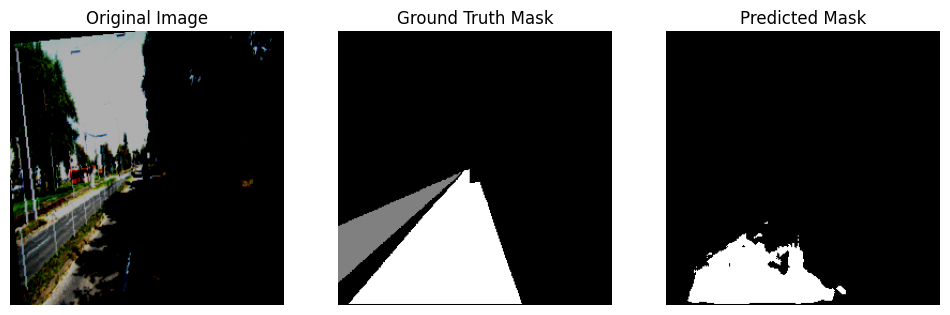

In [7]:
import torch
import matplotlib.pyplot as plt


def predict_and_visualize(model, dataset, idx, device="mps"):
    model.eval()
    sample = dataset[idx]
    image = sample['image'].unsqueeze(0).to(device)
    gt_mask = sample['road_gt']

    with torch.no_grad():
        output = model(image)

    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Convert CHW -> HWC
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(gt_mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    ax[2].imshow(predicted_mask, cmap="gray")
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")

    plt.show()


predict_and_visualize(ensemble_model, dataset, idx=12, device=device)